In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math,copy,time
from torch.autograd import Variable
%matplotlib inline 
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ModuleNotFoundError: No module named 'seaborn'

In [2]:
class EncoderDecoder(nn.Module):
    '''
    High Level structure of the NMT model
    '''
    
    def __init__(self,encoder, # input word to vector
                decoder, # hidden  to vector
                x_emb, # input representation layers
                y_emb, # output representation
                clf): # final classifier , pick the right word.
        super(EncoderDecoder,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.x_emb = x_emb
        self.y_emb = y_emb
        self.clf = clf
        
    
    def forward(self, x,
               y,
               x_mask,
               y_mask):
        h = self.encoder(x,x_mask)
        y = self.decoder(h,x_mask, # attention 
                        y,y_mask)
        return y
    
    def encoder(self,x,x_mask):
        return self.encoder(self.x_emb(x),x_mask) # getting the hidden state matrix
    
    def decoder(self,hidden_matrix,x_mask,y,y_mask):
        return self.decoder(self.y_emb(y),hidden_matrix,#dot_product
                           x_mask,y_mask)
    
class Classifier(nn.Module):
    def __init__(self,dimension,vocab):
        super(Classifier,self).__init__()
        self.fc = nn.Linear(dimension,vocab)
        
    def forward(self,x):
        return F.log_softmax(self.fc(x),dim = -1) # So the loss would be NNloss
       

In [3]:
def clones(module,N):
    return nn.ModuleList(*[copy.deepcopy(module) for _ in range(N)])

In [4]:
class Encoder(nn.Module):
    def __init__(self,layer, N):
        super(Encoder,self).__init__()
        self.layers = clone(layer,N)
        self.norm = LayerNorm(layer.size) # later when you initialize layer
       
        
    def forward(self,x,x_mask):
        for lyer in self.layers:
            x = lyer(x,x_mask)
        x = self.norm(x)
        
        return x     

In [5]:
class Layernorm(nn.Module): # Layer norm is not batch norm ! #it norm for features in the instance
    def __init__(self,features, eps = 1e-6):
        super(Layernorm,self).__init__()
        self.eps = eps
        
    def forward(self,x):
        mean = torch.mean(x,dim = -1)
        std = torch.std(x,dim = -1)
        return (x - mean)/(std + self.eps)**0.5 # Based on the original paper
    
    
    

In [6]:
class SublayerConnection(nn.Module):
    
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = Layernorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x))) # residual
    

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self,size,self_attn,fc,dropout):
        super(EncoderLayer).__init__()
        self.attn = self_attn
        self.fc = fc
        self.sublayer = clones(SublayerConnection(size,dropout),2)

### Decoder

In [8]:
class Decoder(nn.Module):
    def __init__(self,layers,N):
        super(Decoder,self).__init__()
        self.layers = clones(layers,N)
        self.norm = Layernorm(layer.size)
        
    def forward(self,x,hidden,x_mask,y_mask):
        for lyer in self.layers:
            x = layer(x,hidden,x_mask,y_mask)
        return self.norm(x)

In [9]:
class DecoderLayer(nn.Module):
    def __init__(self,size, self_attn, x_attn, fc, dropout):
        super(DecoderLayer,self).__init__()
        self.size = size
        self.attn = self_attn
        self.x_attn = x_attn
        self.fc = fc
        self.sublayers = clones(SublayerConnection(size,dropout),3)
        
    def forward(self,x,hidden ,x_mask,y_mask):
        x = self.sublayers[0](x,lambda x: self.attn(x,x,x,y_mask))
        x = slef.sublayers[1](x, lambda x: self.x_attn(x,m,m,x_mask))
        return self.sublayers[2](x,self.fc)
    
    
        

In [10]:
def sebsequent(size):
    attn_shape = (1,size,size)
    subseq_mask = np.triu(np.ones(attn_shape),k = 1).astype('uint8')
    return torch.from_numpy(subseq_mask) == 0

tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
      

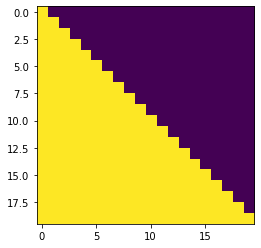

In [11]:
plt.imshow(sebsequent(20)[0])
sebsequent(20)

In [12]:
def Attn(k,q,v,mask = None, dropout = None):
    d_k = q.size(-1)
    scores = torch.matmul(q,k.transpose(-2,-1))/math.sqrt(d_k)
    
    if mask is not None:
        scores = scores.masked_fill(mask ==0, -1e9)
    weight = F.softmax(scores,dim = -1)
    
    if dropout is not None:
        weight = dropout(weight)
        
    return torch.matmul(weight,v),weight

In [13]:
class MultiAttn(nn.Module):
    def __init__(self,h,d_model,dropout = 0.1):
        super(MultiAttn,self).__init__()
        assert d_model%h == 0
        self.d_k = d_model//h
        self.h = h
        self.fcs = clone(nn.Linear(d_model,d_model),4)
        self.attn = None
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,q,k,v,mask = None):
        if mask is not None:
            mask = mask.unsqueeze(1) # add dimension
        batch_size = q.size(0)
        factor = [l(x).view(batch_size,-1,self.h,self.d_k) for l,x in zip(self.fcs,q,k,v)]
            
        x,self.attn = Attn(*factor,mask=mask, dropout=self.dropout)
        
        x = x.transpose(1,2).contiguous().view(batch_size,-1,self.h*self.d_k)
        return self.fcs[-1](x)
    

In [14]:
class PositionFC(nn.Module):
    def __init__(self,d_model,d_ff,dropout = 0.1):
        super(PositionFC,self).__init__()
        self.w_1 = nn.Linear(d_model,d_ff)
        self.w_2 = nn.Linear(d_ff,d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,x):
        x = F.relu(self.w_1(x))
        x = self.dropout(x)
        x = self.w_2(x)
        
        return x
    
    
class Embeding(nn.Module):
    def __init__(self,d_model,vocab):
        super(Embeding,self).__init__()
        self.emb = nn.Embedding(vocab,d_model)
        self.d_model = d_model
        
    def forward(self,x):
        return self.emb(x) * math.sqrt(self.d_model)

In [7]:
class PositionEncoding(nn.Module):
    def __init__(self,d_model,dropout,max_len = 500):
        super(PositionEncoding,self).__init__()
        self.drop = nn.Dropout(dropout)
        
        positionEncode = torch.zeros(max_len,d_model)
        position = torch.arange(0,max_len).unsqueeze(1) # max_len,1
        div_term = torch.exp(torch.arange(0,d_model,2) * -(math.log(10000.0)/d_model))
        
        positionEncode[:,0::2] = torch.sin(position*div_term) # even
        positionEncode[:,1::2] = torch.cos(position*div_term) # odd
        positionEncode = positionEncode.unsequeeze(0) # add dimension in forst axis
        self.register_buffer('pe',positionEncode)
        
    def forward(self,x):
        x = x +Variable(self.positionEncode[:,:x.size(1)],
                       require_grad = False)
        return self.dropout(x)

In [24]:
torch.zeros(30,50)[:,0::2].size()

torch.Size([30, 25])

In [26]:
np.arange(0,10)[0::2]

array([0, 2, 4, 6, 8])